#DBScan

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, pairwise_distances

##Load dataset

In [3]:
customers = pd.read_csv("/content/drive/MyDrive/DM/Clustering/customer_indicators.csv", sep=",", index_col=0)
customers.describe()

,TotalProducts,distance_in_time_purchase,Qta_entropy,Qta_mean,Sale_entropy,Sale_mean
count,4110.000000,4110.000000,4110.000000,4110.000000,4110.000000,4110.000000
mean,0.103617,0.504197,0.267264,0.193016,0.284535,0.176307
std,0.135399,0.409830,0.323076,0.148708,0.336149,0.144312
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.021565,0.122115,0.000000,0.087842,0.000000,0.072594
50%,0.053399,0.307692,0.000000,0.155963,0.000000,0.139115
75%,0.129801,1.000000,0.579380,0.258945,0.612602,0.242893
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [4]:
np_data = customers.values

##Make *k*-th neighbour distance plot

In [5]:
# For each point, compute the distance from its k-th nearest neighbour
def compute_kth_distance(data, k):
  dist = []
  for elem in data:
    distances = np.linalg.norm(data - elem, axis=1, ord=2)
    distances.sort()
    dist.append(distances[k])

  dist.sort()
  return dist

# Plot increasing k-th distances
def make_kth_distance_plot(data, ks):
  plt.figure(figsize=(10,6))

  x = range(len(data))
  for k in ks:
    l = "K = " + str(k)
    plt.plot(x, compute_kth_distance(data, k), label=l)

  plt.gca().set(ylabel="Distance")
  plt.grid()
  plt.legend()
  plt.tight_layout()

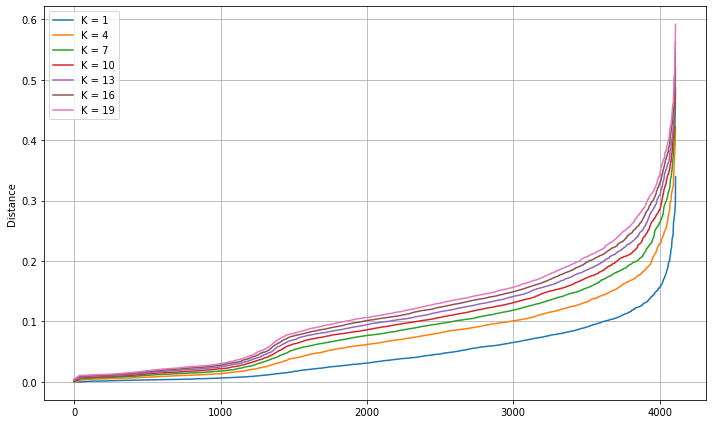

In [7]:
make_kth_distance_plot(np_data, range(1, 20, 3))
plt.savefig("./knearest.png")
#plt.savefig("/content/drive/MyDrive/DM/Clustering/DBScan/knearest.png")

##Clustering and clusters statistics

In [8]:
# Execute DBScan. The parameters have been adjusted by hand
db = DBSCAN(eps = 0.2, min_samples = 10, metric='euclidean').fit(np_data)

In [9]:
# Compute statistics for each found cluster
n_clusters = len(set(db.labels_)) - (1 if -1 in db.labels_ else 0)
n_noise = list(db.labels_).count(-1)
silhouette = silhouette_score(np_data, db.labels_)

core_sample_mask = np.zeros_like(db.labels_, dtype=bool)
core_sample_mask[db.core_sample_indices_] = True

clusters_size = np.zeros(n_clusters)
clusters_core_size = np.zeros(n_clusters)
clusters_sse = np.zeros(n_clusters)

for i in range(n_clusters):
  class_member_mask = (db.labels_ == i)

  # Cluster size
  clusters_size[i] = list(db.labels_).count(i);

  # Cluster core size
  clusters_core_size[i] = np.sum(class_member_mask & core_sample_mask)

  # Cluster SSE
  temp = np_data[class_member_mask]
  dist = pairwise_distances(temp)
  clusters_sse[i] = np.sum(np.mean(dist, axis=0))


In [11]:
print("Number of clusters: %d" % n_clusters)
for i in range(n_clusters):
  print("Cluster %d:" % i)
  print("    Size: %d (core: %d)" % (clusters_size[i], clusters_core_size[i]))
  print("    SSE:  %0.3f" % clusters_sse[i])
  print("    MSE:  %0.3f" % (clusters_sse[i]/clusters_size[i]))
print("Number of noise points: %d" % n_noise)
print("Silhouette score: %0.3f" % silhouette)

Number of clusters: 5
Cluster 0:
    Size: 1317 (core: 1213)
    SSE:  581.968
    MSE:  0.442
Cluster 1:
    Size: 337 (core: 306)
    SSE:  118.149
    MSE:  0.351
Cluster 2:
    Size: 1886 (core: 1849)
    SSE:  780.610
    MSE:  0.414
Cluster 3:
    Size: 406 (core: 369)
    SSE:  158.864
    MSE:  0.391
Cluster 4:
    Size: 19 (core: 13)
    SSE:  3.475
    MSE:  0.183
Number of noise points: 145
Silhouette score: 0.425


In [12]:
# Add "cluster" column to dataframe
df_clusters = customers.copy()
df_clusters["cluster"] = db.labels_

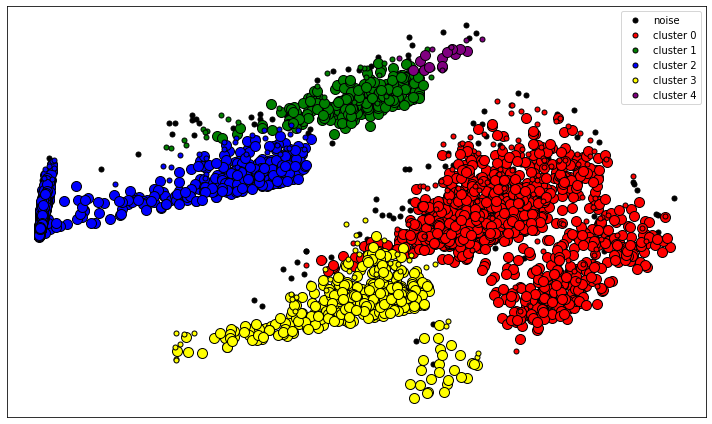

In [14]:
# 2D visualization of the clusters
# Big colored points are core points. Small colored points are border points
# Black points are the noise
from sklearn.decomposition import PCA
X_pca = PCA(n_components=2).fit_transform(np_data)

colors = ['red', 'green', 'blue', 'yellow', 'purple']

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot()

X_noise = X_pca[(db.labels_ == -1)]
ax.plot(X_noise[:, 0], X_noise[:, 1], 'o', markerfacecolor='black', markeredgecolor='k', markersize=5, label="noise")

for i in range(n_clusters):
  class_member_mask = (db.labels_ == i)
  X_core = X_pca[class_member_mask & core_sample_mask]
  X_border = X_pca[class_member_mask & ~core_sample_mask]

  plt.plot(X_core[:, 0], X_core[:, 1], 'o',  markerfacecolor=colors[i], markeredgecolor='k', markersize=10)
  plt.plot(X_border[:, 0], X_border[:, 1], 'o',  markerfacecolor=colors[i], markeredgecolor='k', markersize=5, label="cluster "+str(i))

plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
plt.legend()
plt.tight_layout()
plt.savefig("./2d-clusters.png")
#plt.savefig("/content/drive/MyDrive/DM/Clustering/DBScan/2d-clusters.png")

In [27]:
# 3D visualization of the clusters
# Colored points are clusters points
# Dark blue points are the noise
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px
label = db.labels_
X_pca = PCA(n_components=3).fit_transform(np_data)

x = X_pca[:,0]
y = X_pca[:,1]
z = X_pca[:,2]

fig = px.scatter_3d(X_pca, x=x, y=y, z=z, color=label)
fig.update_traces(marker=dict(size=3))

fig.show()

In [43]:
# Remove noise points from the dataset for the statistics
df_clusters_clean = df_clusters[df_clusters.cluster != -1]

In [63]:
cluster_0 = df_clusters[df_clusters.cluster == 0]
cluster_0 = cluster_0.rename(columns={"distance_in_time_purchase": "distance_in_time"})

cluster_1 = df_clusters[df_clusters.cluster == 1]
cluster_1 = cluster_1.rename(columns={"distance_in_time_purchase": "distance_in_time"})

cluster_2 = df_clusters[df_clusters.cluster == 2]
cluster_2 = cluster_2.rename(columns={"distance_in_time_purchase": "distance_in_time"})

cluster_3 = df_clusters[df_clusters.cluster == 3]
cluster_3 = cluster_3.rename(columns={"distance_in_time_purchase": "distance_in_time"})

cluster_4 = df_clusters[df_clusters.cluster == 4]
cluster_4 = cluster_4.rename(columns={"distance_in_time_purchase": "distance_in_time"})

columns = ['TotalProducts','distance_in_time','Qta_entropy','Qta_mean','Sale_entropy','Sale_mean']

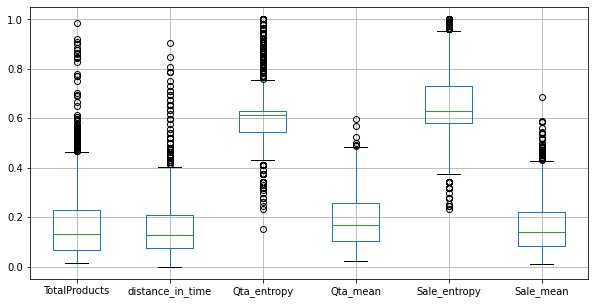

In [65]:
cluster_0[columns].boxplot(figsize=(10,5))
plt.savefig('./box_plot_cluster0.png')
#plt.savefig('/content/drive/MyDrive/DM/Clustering/DBScan/box_plot_cluster0.png')

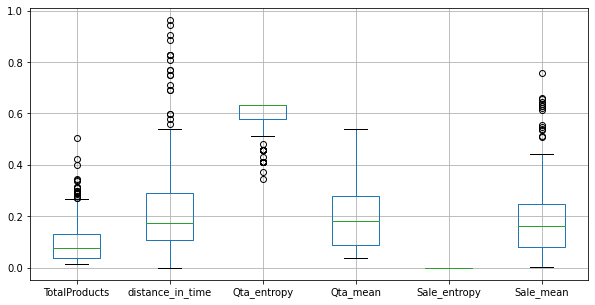

In [66]:
cluster_1[columns].boxplot(figsize=(10,5))
plt.savefig('./box_plot_cluster1.png')
#plt.savefig('/content/drive/MyDrive/DM/Clustering/DBScan/box_plot_cluster1.png')

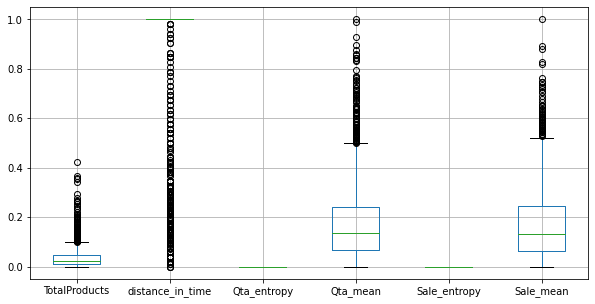

In [67]:
cluster_2[columns].boxplot(figsize=(10,5))
plt.savefig('./box_plot_cluster2.png')
#plt.savefig('/content/drive/MyDrive/DM/Clustering/DBScan/box_plot_cluster2.png')

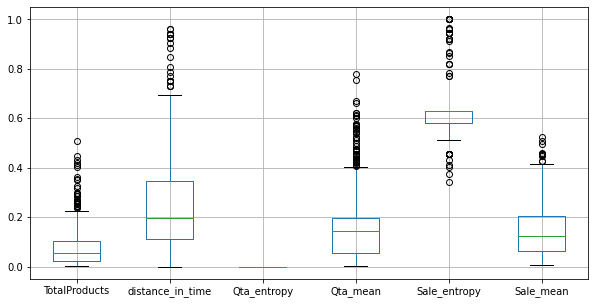

In [68]:
cluster_3[columns].boxplot(figsize=(10,5))
plt.savefig('./box_plot_cluster3.png')
#plt.savefig('/content/drive/MyDrive/DM/Clustering/DBScan/box_plot_cluster3.png')

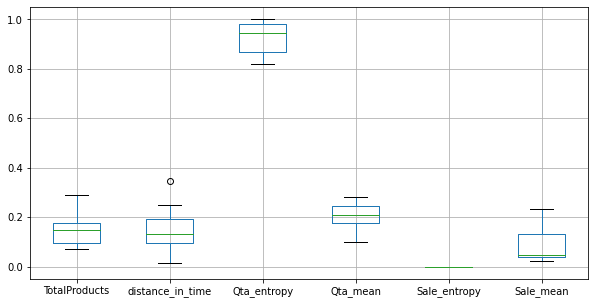

In [69]:
cluster_4[columns].boxplot(figsize=(10,5))
plt.savefig('./box_plot_cluster4.png')
#plt.savefig('/content/drive/MyDrive/DM/Clustering/DBScan/box_plot_cluster4.png')

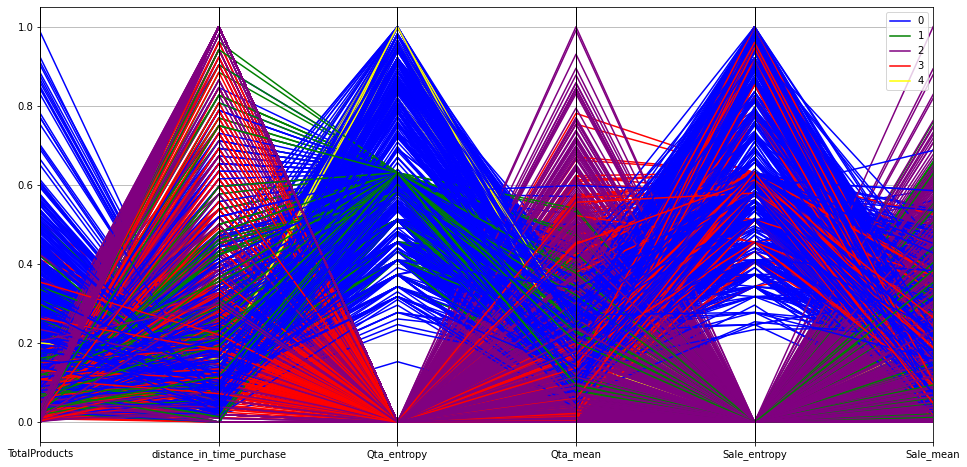

In [ ]:
# Parallel coordinates plot
fig = plt.figure(figsize=(16,8))
pd.plotting.parallel_coordinates(df_clusters_clean, "cluster", color=colors, sort_labels=True)

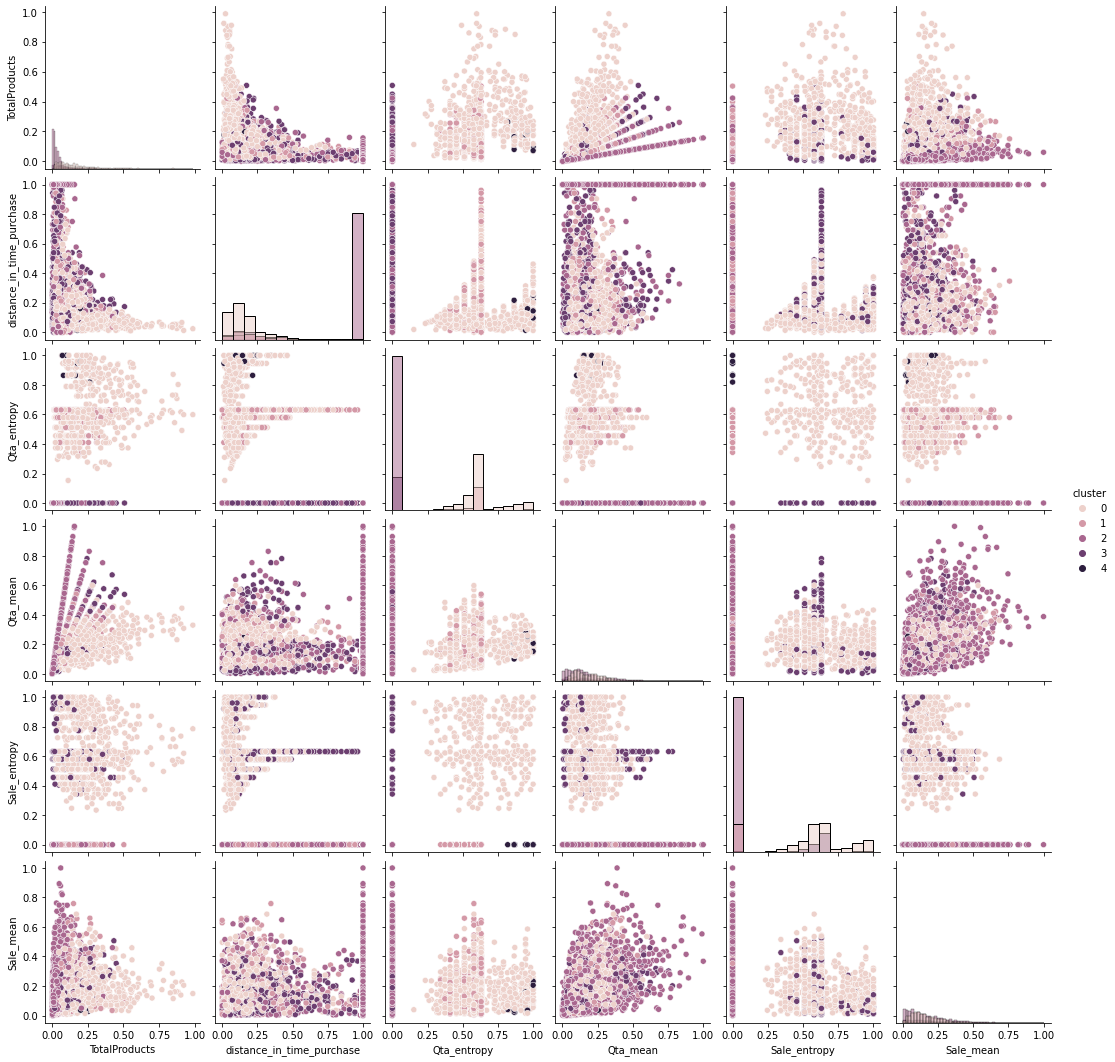

In [ ]:
# Pairplot
ax = sns.pairplot(df_clusters_clean, hue="cluster", diag_kind="hist")

##Clusters analysis

In [28]:
# Load indicators dataset, add cluster for each customer and remove noise
df = pd.read_csv("/content/drive/MyDrive/DM/DM_old/customer_indicators_all_features_unnormalized.csv", sep=",", index_col=0)
df["cluster"] = db.labels_
df = df[df.cluster != -1]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3965 entries, 0 to 4171
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   CustomerID                 3965 non-null   int64  
 1   NumBaskets                 3965 non-null   int64  
 2   NumProducts                3965 non-null   int64  
 3   TotalProducts              3965 non-null   int64  
 4   MaxProd                    3965 non-null   int64  
 5   distance_in_time_purchase  3965 non-null   float64
 6   Qta_entropy                3965 non-null   float64
 7   Qta_mean                   3965 non-null   float64
 8   #ProdID_entropy            3965 non-null   float64
 9   #ProdID_mean               3965 non-null   float64
 10  Tot_entropy                3965 non-null   float64
 11  Tot_mean                   3965 non-null   float64
 12  Sale_entropy               3965 non-null   float64
 13  Sale_mean                  3965 non-null   float

In [29]:
# Load transactions dataset
df_raw = pd.read_csv("/content/drive/MyDrive/DM/Data_Preparation/customer_supermarket_cleaned_orders.csv", sep="\t", index_col=0)
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 405715 entries, 536365 to 581587
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   ProdID             405715 non-null  object 
 1   BasketDate         405715 non-null  object 
 2   CustomerCountry    405715 non-null  object 
 3   Sale               405715 non-null  float64
 4   CustomerID         344943 non-null  float64
 5   ProdDescr          405715 non-null  object 
 6   Qta                405715 non-null  int64  
 7   BasketDay          405715 non-null  int64  
 8   BasketMonth        405715 non-null  int64  
 9   BasketWeekOfYear   405715 non-null  int64  
 10  BasketYear         405715 non-null  int64  
 11  BasketWeekOfMonth  405715 non-null  int64  
 12  Tot                405715 non-null  float64
dtypes: float64(3), int64(6), object(4)
memory usage: 43.3+ MB


In [31]:
cluster_0.describe()

,CustomerID,NumBaskets,NumProducts,TotalProducts,MaxProd,distance_in_time_purchase,Qta_entropy,Qta_mean,#ProdID_entropy,#ProdID_mean,Tot_entropy,Tot_mean,Sale_entropy,Sale_mean,cluster
count,1317.000000,1317.000000,1317.000000,1317.000000,1317.000000,1317.000000,1317.000000,1317.000000,1317.000000,1317.000000,1317.000000,1317.00000,1317.000000,1317.000000,1317.0
mean,15311.388003,6.630220,83.972665,846.404708,254.343964,9.353481,0.628625,144.139064,0.483656,19.898909,0.539986,247.75653,0.653928,55.894166,0.0
std,1682.325390,5.342873,66.890437,728.258937,142.042775,6.781960,0.151763,76.281320,0.286077,13.501384,0.272037,125.34715,0.165952,36.413189,0.0
min,12347.000000,2.000000,6.000000,69.000000,36.000000,1.000000,0.152869,17.571429,0.000000,2.200000,0.000000,33.38500,0.234222,3.196000,0.0
25%,13939.000000,3.000000,37.000000,335.000000,140.000000,4.800000,0.544568,80.333333,0.373304,10.500000,0.455486,152.91000,0.579380,28.980000,0.0
50%,15235.000000,5.000000,66.000000,643.000000,234.000000,7.666667,0.612602,130.466667,0.579380,17.142857,0.579380,227.90000,0.630930,47.571429,0.0
75%,16747.000000,8.000000,110.000000,1108.000000,330.000000,11.750000,0.630930,197.500000,0.630930,25.250000,0.630930,322.74000,0.729847,76.026667,0.0
max,18287.000000,43.000000,435.000000,4803.000000,971.000000,48.000000,1.000000,457.666667,1.000000,92.750000,1.000000,947.31000,1.000000,234.543333,0.0


In [32]:
cluster_1.describe()

,CustomerID,NumBaskets,NumProducts,TotalProducts,MaxProd,distance_in_time_purchase,Qta_entropy,Qta_mean,#ProdID_entropy,#ProdID_mean,Tot_entropy,Tot_mean,Sale_entropy,Sale_mean,cluster
count,337.000000,337.000000,337.000000,337.000000,337.000000,337.000000,337.000000,337.000000,337.000000,337.000000,337.000000,337.000000,337.0,337.000000,337.0
mean,15268.154303,3.406528,58.246291,483.017804,225.952522,12.837797,0.592030,148.632325,0.382295,21.804260,0.444562,262.187713,0.0,63.376894,1.0
std,1773.325129,1.863900,49.425526,391.954139,140.667195,9.473379,0.058298,86.966134,0.308746,16.421505,0.295451,148.425598,0.0,48.031853,0.0
min,12348.000000,2.000000,4.000000,69.000000,60.000000,1.000000,0.342951,29.000000,0.000000,1.666667,0.000000,30.066667,0.0,1.300000,1.0
25%,13727.000000,2.000000,23.000000,178.000000,103.000000,6.666667,0.579380,67.666667,0.000000,10.500000,0.000000,151.860000,0.0,27.400000,1.0
50%,15349.000000,3.000000,46.000000,380.000000,216.000000,10.000000,0.630930,139.000000,0.579380,17.833333,0.579380,227.675000,0.0,54.950000,1.0
75%,16771.000000,4.000000,78.000000,633.000000,303.000000,16.000000,0.630930,212.000000,0.630930,28.250000,0.630930,364.350000,0.0,85.115000,1.0
max,18265.000000,13.000000,283.000000,2450.000000,751.000000,51.000000,0.630930,413.000000,1.000000,111.333333,1.000000,908.490000,0.0,258.886667,1.0


In [33]:
cluster_2.describe()

,CustomerID,NumBaskets,NumProducts,TotalProducts,MaxProd,distance_in_time_purchase,Qta_entropy,Qta_mean,#ProdID_entropy,#ProdID_mean,Tot_entropy,Tot_mean,Sale_entropy,Sale_mean,cluster
count,1886.000000,1886.000000,1886.000000,1886.000000,1886.000000,1886.000000,1886.0,1886.000000,1886.000000,1886.000000,1886.000000,1886.000000,1886.000000,1886.000000,1886.0
mean,15316.948038,1.324496,25.172322,178.421527,143.165429,46.195520,0.0,139.275557,0.037141,20.764767,0.027191,239.153960,0.000307,58.709760,2.0
std,1717.887611,0.738989,25.770678,199.332911,126.052602,15.133608,0.0,120.319103,0.147048,18.691865,0.126499,184.989538,0.013341,50.305767,0.0
min,12350.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,0.000000,1.000000,0.000000,1.900000,0.000000,0.290000,2.0
25%,13826.500000,1.000000,8.000000,59.000000,54.000000,53.000000,0.0,52.000000,0.000000,8.000000,0.000000,111.390000,0.000000,21.165000,2.0
50%,15334.500000,1.000000,18.000000,117.000000,110.000000,53.000000,0.0,105.750000,0.000000,16.000000,0.000000,194.232500,0.000000,45.066667,2.0
75%,16783.250000,1.000000,32.000000,232.000000,188.000000,53.000000,0.0,184.000000,0.000000,28.000000,0.000000,313.601250,0.000000,83.860000,2.0
max,18282.000000,8.000000,309.000000,2061.000000,914.000000,53.000000,0.0,764.000000,1.000000,138.000000,0.946395,1290.700000,0.579380,341.160000,2.0


In [34]:
cluster_3.describe()

,CustomerID,NumBaskets,NumProducts,TotalProducts,MaxProd,distance_in_time_purchase,Qta_entropy,Qta_mean,#ProdID_entropy,#ProdID_mean,Tot_entropy,Tot_mean,Sale_entropy,Sale_mean,cluster
count,406.000000,406.000000,406.000000,406.000000,406.000000,406.000000,406.0,406.000000,406.000000,406.000000,406.000000,406.000000,406.000000,406.000000,406.0
mean,15440.251232,3.366995,47.669951,406.460591,167.044335,14.743484,0.0,131.922653,0.246138,18.172549,0.191160,229.230926,0.622929,50.269618,3.0
std,1752.735228,2.045361,44.653447,414.275941,149.058901,10.992327,0.0,114.738499,0.291800,14.335587,0.277112,177.464716,0.098851,36.872051,0.0
min,12358.000000,2.000000,2.000000,16.000000,6.000000,1.000000,0.0,3.333333,0.000000,1.000000,0.000000,9.140000,0.342951,1.930000,3.0
25%,13813.750000,2.000000,19.000000,110.500000,55.250000,6.812500,0.0,41.812500,0.000000,7.541667,0.000000,97.041250,0.579380,21.170000,3.0
50%,15620.000000,3.000000,34.000000,276.500000,141.000000,11.250000,0.0,109.375000,0.000000,13.916667,0.000000,197.220333,0.630930,41.886667,3.0
75%,16964.500000,4.000000,61.000000,506.750000,189.750000,19.000000,0.0,149.375000,0.579380,26.000000,0.511860,281.611250,0.630930,70.297188,3.0
max,18270.000000,17.000000,314.000000,2472.000000,805.000000,51.000000,0.0,597.000000,0.886860,84.400000,0.946395,962.006667,1.000000,179.485000,3.0


In [35]:
cluster_4.describe()

,CustomerID,NumBaskets,NumProducts,TotalProducts,MaxProd,distance_in_time_purchase,Qta_entropy,Qta_mean,#ProdID_entropy,#ProdID_mean,Tot_entropy,Tot_mean,Sale_entropy,Sale_mean,cluster
count,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.0,19.000000,19.0
mean,15063.157895,5.000000,52.894737,753.105263,302.736842,8.770677,0.929356,159.236153,0.625944,15.025251,0.600298,201.865692,0.0,30.551050,4.0
std,1749.115690,1.885618,20.242680,309.443568,89.851632,4.028118,0.059336,37.017428,0.225483,6.967785,0.257380,77.245934,0.0,24.883258,0.0
min,12399.000000,3.000000,23.000000,353.000000,214.000000,1.666667,0.819448,77.800000,0.000000,7.200000,0.000000,102.768571,0.0,7.610000,4.0
25%,13573.000000,4.000000,39.500000,465.500000,230.000000,6.000000,0.867445,136.166667,0.545620,10.812500,0.545620,144.358875,0.0,13.016500,4.0
50%,15582.000000,5.000000,46.000000,729.000000,266.000000,7.833333,0.946395,159.333333,0.612602,13.200000,0.612602,190.245000,0.0,16.180000,4.0
75%,16262.000000,5.500000,70.000000,863.000000,344.500000,11.000000,0.980115,188.725000,0.626270,18.333333,0.677882,230.210000,0.0,44.953333,4.0
max,17779.000000,10.000000,90.000000,1404.000000,508.000000,19.000000,1.000000,216.000000,1.000000,31.333333,0.946395,379.295000,0.0,79.383333,4.0


In [36]:
# Print statistics about a particular customer
def infos(id):
  print("CustomerID: " + str(id))
  print("NumBaskets: " + str(df[df.CustomerID == id].NumBaskets.values))

  customer_info = df_raw[df_raw.CustomerID == id]
  
  res = customer_info.groupby("BasketID").ProdID.count().reset_index().values[:,1]
  print("Distinct products per basket: " + str(res))

  res = customer_info.groupby("BasketID").Qta.sum().reset_index().values[:,1]
  print("Qta per basket: " + str(res))

  res = customer_info.groupby("BasketID").Sale.sum().reset_index().values[:,1]
  print("Sale per basket: " + str(res))

  res = customer_info.groupby("BasketID").Tot.sum().reset_index().values[:,1]
  print("Total per basket: " + str(res))

In [37]:
idxs = np.random.random(10) * len(customers_0)
for idx in idxs:
  id = customers_0[int(idx)]
  infos(id)
  print("")

CustomerID: 17905
NumBaskets: [3]
Distinct products per basket: [22  2  4]
Qta per basket: [72 25 40]
Sale per basket: [108.65   3.75   5.47]
Total per basket: [201.75  48.    46.34]

CustomerID: 12682
NumBaskets: [30]
Distinct products per basket: [14 30 36 16 16 17 25 22  6  8 16  9 17 14  9  8  4 24 21 15 17  7 14 19
 11 12  8  3 16 28]
Qta per basket: [121 315 345 146 135 124 245 190  58  38 128  65 139 184  72  96  32 178
 184 164 177  60 138 205  95 100  82  20 148 276]
Sale per basket: [43.12 62.3  91.98 56.65 54.37 62.35 64.45 59.21 17.83 45.67 44.72 28.75
 55.78 26.64 16.65 21.19 10.7  76.09 58.07 30.79 65.77 11.75 34.96 48.13
 29.33 34.18 29.83  9.15 36.48 99.12]
Total per basket: [246.69 506.25 608.31 315.4  312.09 264.   453.55 400.58 121.88 126.54
 275.96 132.55 364.15 291.48 124.8  197.1   81.6  376.88 392.8  240.28
 321.01  95.4  235.58 349.17 180.51 227.4  191.8   49.8  283.04 539.67]

CustomerID: 14973
NumBaskets: [3]
Distinct products per basket: [ 3 19  5]
Qta per ba

In [ ]:
idxs = np.random.random(10) * len(customers_1)
for idx in idxs:
  id = customers_1[int(idx)]
  infos(id)
  print("")

CustomerID: 17892
NumBaskets: [2]
Distinct products per basket: [26  1]
Qta per basket: [69  4]
Sale per basket: [86.6   2.55]
Total per basket: [142.1  10.2]

CustomerID: 12942
NumBaskets: [3]
Distinct products per basket: [16  8 46]
Qta per basket: [69 35 99]
Sale per basket: [ 87.55  47.14 167.35]
Total per basket: [258.75 137.77 287.38]

CustomerID: 14844
NumBaskets: [4]
Distinct products per basket: [38 23 20 39]
Qta per basket: [464 232 165 364]
Sale per basket: [104.35  73.33  71.33 125.33]
Total per basket: [642.45 392.9  356.33 611.21]

CustomerID: 15469
NumBaskets: [2]
Distinct products per basket: [16  7]
Qta per basket: [128  21]
Sale per basket: [64.55 58.75]
Total per basket: [304.3  151.05]

CustomerID: 17621
NumBaskets: [3]
Distinct products per basket: [2 5 8]
Qta per basket: [12 58 88]
Sale per basket: [ 5.9  16.42 24.48]
Total per basket: [ 35.4  120.78 182.32]

CustomerID: 17062
NumBaskets: [4]
Distinct products per basket: [25 12 13 17]
Qta per basket: [151  95  78

In [ ]:
idxs = np.random.random(10) * len(customers_4)
for idx in idxs:
  id = customers_4[int(idx)]
  infos(id)
  print("")

CustomerID: 16218
NumBaskets: [5]
Distinct products per basket: [27  8  4  9  7]
Qta per basket: [402 126  40 128 106]
Sale per basket: [31.9  13.9   7.84 15.71 11.55]
Total per basket: [440.7  216.3   67.76 195.72 170.7 ]

CustomerID: 16306
NumBaskets: [5]
Distinct products per basket: [ 1 12 18  3  3]
Qta per basket: [ 12 119 224  12  22]
Sale per basket: [ 1.25 21.9  28.18  2.92  5.9 ]
Total per basket: [ 15.   168.85 294.5   10.82  37.8 ]

CustomerID: 13107
NumBaskets: [4]
Distinct products per basket: [16 11 14  2]
Qta per basket: [266 186 237  40]
Sale per basket: [21.08 19.15 23.22  0.84]
Total per basket: [276.62 236.38 231.18  16.8 ]

CustomerID: 16306
NumBaskets: [5]
Distinct products per basket: [ 1 12 18  3  3]
Qta per basket: [ 12 119 224  12  22]
Sale per basket: [ 1.25 21.9  28.18  2.92  5.9 ]
Total per basket: [ 15.   168.85 294.5   10.82  37.8 ]

CustomerID: 14064
NumBaskets: [5]
Distinct products per basket: [11  7  6 25 17]
Qta per basket: [119  42  94 218 203]
Sale 

In [ ]:
idxs = np.random.random(10) * len(customers_3)
for idx in idxs:
  id = customers_3[int(idx)]
  infos(id)
  print("")

CustomerID: 17312
NumBaskets: [2]
Distinct products per basket: [9 2]
Qta per basket: [58  2]
Sale per basket: [17.85  8.9 ]
Total per basket: [95.4  8.9]

CustomerID: 12885
NumBaskets: [3]
Distinct products per basket: [39 30  1]
Qta per basket: [346 269  16]
Sale per basket: [163.35  89.16   0.65]
Total per basket: [645.35 472.67  10.4 ]

CustomerID: 14133
NumBaskets: [3]
Distinct products per basket: [16 10  1]
Qta per basket: [152 136  24]
Sale per basket: [81.9  22.68  0.83]
Total per basket: [318.   237.12  19.92]

CustomerID: 14173
NumBaskets: [4]
Distinct products per basket: [11 11  4  1]
Qta per basket: [40 27 37  6]
Sale per basket: [56.12 48.18  6.4   2.08]
Total per basket: [114.04  88.17  59.55  12.48]

CustomerID: 14880
NumBaskets: [3]
Distinct products per basket: [ 8 17 21]
Qta per basket: [ 66 179 128]
Sale per basket: [27.25 52.42 94.07]
Total per basket: [129.2  234.07 342.92]

CustomerID: 13539
NumBaskets: [3]
Distinct products per basket: [10 10 16]
Qta per basket

In [ ]:
idxs = np.random.random(10) * len(customers_2)
for idx in idxs:
  id = customers_2[int(idx)]
  infos(id)
  print("")

CustomerID: 13826
NumBaskets: [1]
Distinct products per basket: [10]
Qta per basket: [82]
Sale per basket: [57.3]
Total per basket: [189.5]

CustomerID: 12425
NumBaskets: [1]
Distinct products per basket: [31]
Qta per basket: [304]
Sale per basket: [84.79]
Total per basket: [509.84]

CustomerID: 15623
NumBaskets: [1]
Distinct products per basket: [19]
Qta per basket: [125]
Sale per basket: [81.52]
Total per basket: [301.03]

CustomerID: 18082
NumBaskets: [1]
Distinct products per basket: [57]
Qta per basket: [417]
Sale per basket: [125.3]
Total per basket: [610.61]

CustomerID: 12426
NumBaskets: [1]
Distinct products per basket: [29]
Qta per basket: [254]
Sale per basket: [100.09]
Total per basket: [510.73]

CustomerID: 15030
NumBaskets: [1]
Distinct products per basket: [1]
Qta per basket: [24]
Sale per basket: [0.85]
Total per basket: [20.4]

CustomerID: 14954
NumBaskets: [1]
Distinct products per basket: [74]
Qta per basket: [123]
Sale per basket: [203.44]
Total per basket: [285.17]

In [ ]:
customers_2_1 = cluster_2[(cluster_2.NumBaskets == 1)]
customers_2_2 = cluster_2[(cluster_2.NumBaskets > 1)]

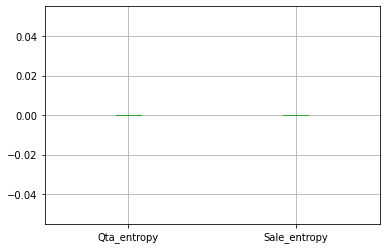

In [ ]:
customers_2_2.boxplot(column=["Qta_entropy", "Sale_entropy"])

In [ ]:
customers_2_2.NumBaskets.unique()

array([3, 2, 4, 5, 6, 7, 8])

In [ ]:
idxs = np.random.random(5) * len(customer_2_1)
for idx in idxs:
  id = customers_2_1.CustomerID.values[int(idx)]
  infos(id)
  print("")

CustomerID: 14148
NumBaskets: [1]
Distinct products per basket: [2]
Qta per basket: [6]
Sale per basket: [9.9]
Total per basket: [29.7]

CustomerID: 13570
NumBaskets: [1]
Distinct products per basket: [25]
Qta per basket: [113]
Sale per basket: [53.39]
Total per basket: [158.37]

CustomerID: 15279
NumBaskets: [1]
Distinct products per basket: [18]
Qta per basket: [141]
Sale per basket: [72.94]
Total per basket: [270.35]

CustomerID: 13740
NumBaskets: [1]
Distinct products per basket: [18]
Qta per basket: [209]
Sale per basket: [34.76]
Total per basket: [266.51]

CustomerID: 15947
NumBaskets: [1]
Distinct products per basket: [17]
Qta per basket: [146]
Sale per basket: [94.14]
Total per basket: [422.64]



In [ ]:
idxs = np.random.random(5) * len(customer_2_2)
for idx in idxs:
  id = customers_2_2.CustomerID.values[int(idx)]
  infos(id)
  print("")

CustomerID: 16356
NumBaskets: [3]
Distinct products per basket: [15  1 15]
Qta per basket: [44  1 48]
Sale per basket: [32.87  2.1  33.27]
Total per basket: [102.     2.1  107.67]

CustomerID: 15883
NumBaskets: [2]
Distinct products per basket: [20 29]
Qta per basket: [ 72 151]
Sale per basket: [64.79 79.99]
Total per basket: [143.76 252.72]

CustomerID: 17339
NumBaskets: [2]
Distinct products per basket: [4 1]
Qta per basket: [16  4]
Sale per basket: [15.    3.75]
Total per basket: [60. 15.]

CustomerID: 15897
NumBaskets: [2]
Distinct products per basket: [ 5 14]
Qta per basket: [15 44]
Sale per basket: [ 7.11 33.93]
Total per basket: [ 9.21 87.22]

CustomerID: 12669
NumBaskets: [2]
Distinct products per basket: [68 29]
Qta per basket: [842 226]
Sale per basket: [138.69  76.68]
Total per basket: [1028.3   391.87]



In [39]:
df_final = df_clusters[(df_clusters.cluster != -1) & (df_clusters.cluster != 4)]
df_final.to_csv("/content/drive/MyDrive/DM/Clustering/customer_indicators_dbscan.csv")